In [51]:
import numpy as np
import pandas as pd
import os 
import sys
import torch

DATASETS = '../datasets/'

def read_file(dir_name):
    main_df = pd.DataFrame()
    directory = DATASETS + dir_name
    for filename in os.listdir(directory):
        data = np.load(os.path.join(directory, filename))
        data_dict = {}
        for keys in data.keys():
            data_dict[keys] = list(data[keys])
        df = pd.DataFrame.from_dict(data_dict)
        main_df = pd.concat([main_df, df])
    return main_df

In [52]:
data = []
for name in os.listdir("../datasets/mw"):
    inner_df = pd.DataFrame()
    if not (name.startswith('.')):
        dir_name = 'mw/'+name
        print(dir_name)
        df = read_file(dir_name)
        inner_df = pd.concat([inner_df, df])    
    data.append(inner_df)
data = np.array(data, dtype=object)


mw/cls_sweep-v2
mw/cls_push-v2
mw/cls_door-open-v2
mw/cls_peg-insert-side-v2
mw/cls_drawer-close-v2
mw/cls_basketball-v2
mw/cls_reach-v2
mw/cls_window-open-v2
mw/cls_pick-place-v2
mw/cls_button_press_topdown-v2


# MAIN CODE

In [53]:
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class Model(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x


class PreferenceMAML:
    def __init__(
        self,
        ml10,
        input_size,
        hidden_size1,
        hidden_size2,
        output_size,
        inner_lr = 0.01,
        num_support=10,
        num_query=10,
        num_inner_steps=5,
        k = 25,
        num_tasks = 10,
        episode_per_task = 1250,
        **kwargs,
    ):
        self.ml10 = ml10
        self.reward_criterion =  nn.BCELoss()
        self.num_support = num_support
        self.num_query = num_query
        self.num_inner_steps = num_inner_steps
        self.inner_lr = inner_lr
        self.k = k
        self.num_tasks = num_tasks
        self.episode_per_task = episode_per_task
        self.num_segments = None
        self.model = Model(input_size, hidden_size1, hidden_size2, output_size)

    def construct_episodes(self, ml10):
        # episodes - n (tasks) x num_episode (each npz file)  , each cell is a dataframe of the episode 
        self.episodes = []
        
        for task in ml10:
            task_episodes=[]
            row_index = task[task['done'] == True].index.tolist()
            prev=0
            for x in row_index:
                task_episodes.append(task[prev:x+1])
                prev=x+1
            task_episodes = np.array(task_episodes,dtype=object)
            self.episodes.append(task_episodes)
        self.episodes = np.array(self.episodes,dtype=object)
        # return episodes

    def form_sigma_groups(self, episode):
        num_segments = int(episode.shape[0] / self.k)
        # print(num_segments)
        if num_segments != 0:
            l_segment = np.array_split(episode.iloc[::-1], num_segments)
            for i in range(len(l_segment)):
                l_segment[i] = l_segment[i].iloc[::-1]
            return l_segment
        else:
            return None

    def compare_probabilities(self, sigma1, sigma2):
        exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
        exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
        prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
        return [0] if prob > 0.5 else [1]

    def prepare_data(self):
        X = []
        y = []
        episodes = self.episodes
        # sigmas = self.form_sigma_groups(episodes, k)
        sigmas = []
        for task in episodes:
            sigma = []
            for episode in task:
                segment = self.form_sigma_groups(episode)
                # print(len(segment))
                if segment is not None:
                    sigma.append(segment)
            # sigma = [self.form_sigma_groups(episode, k) for episode in task]
            sigmas.append(sigma)
        sigmas = np.array(sigmas, dtype=object)
        # for task in sigmas:
        #     for episode in task:
        #         print(len(episode))
            # sigmas = self.form_sigma_groups(episode, k)
            # for _ in range(len(sigmas)):
            #     sigma1 = sigmas[_][0]
            #     sigma2 = sigmas[_][1]

            #     obs_action_sigma1 = []
            #     for row in sigma1:
            #         obs_action = list(row['obs']) + list(row['action']) 
            #         obs_action_sigma1.append(obs_action)

            #     obs_action_sigma2 = []
            #     for row in sigma2:
            #         obs_action = list(row['obs']) + list(row['action'])  
            #         obs_action_sigma2.append(obs_action)

            #     if len(obs_action_sigma1) > len(obs_action_sigma2):
            #         obs_action_sigma1 = obs_action_sigma1[1:]
            #     elif len(obs_action_sigma1) < len(obs_action_sigma2):
            #         obs_action_sigma2 = obs_action_sigma2[1:]
            #     else:
            #         continue

            #     X.append(np.concatenate((obs_action_sigma1, obs_action_sigma2), axis=1))
            #     y.append(self.compare_probabilities(sigma1, sigma2))

        return X, y, sigmas

    def setup_optimizers(self, optim_class, optim_kwargs):
        self.optim = optim_class(self.model.parameters(), **optim_kwargs)

    def _train_step(self, X, y):
        self.optim.zero_grad()
        loss = self._outer_step(X, y)
        loss.backward()
        self.optim.step()
        return loss.item()

    def _outer_step(self, X, y):
        outer_losses = []
        for i in tqdm(range(len(X))):
            if len(X[i])>self.num_support:
                support_X, support_y, query_X, query_y = self._split_support_query(X[i], y[i])
                # Inner loop (adaptation)
                adapted_model = self._inner_loop(support_X, support_y)
                # Compute loss using the adapted model on query set
                query_loss = self._compute_loss(adapted_model, query_X, query_y)
                outer_losses.append(query_loss)
        return torch.mean(torch.stack(outer_losses))

    def _inner_loop(self, support_X, support_y):
        adapted_model = Model(self.model.fc1.in_features, self.model.fc1.out_features,
                              self.model.fc2.out_features, self.model.fc3.out_features)
        adapted_model.load_state_dict(self.model.state_dict())

        inner_optimizer = optim.Adam(adapted_model.parameters(), lr=self.inner_lr)

        for _ in range(self.num_inner_steps):
            inner_optimizer.zero_grad()
            loss = self._compute_loss(adapted_model, support_X, support_y)
            loss.backward()
            inner_optimizer.step()

        return adapted_model
    '''
    R_E = 
    [
        [
            sigma_s1^E1, ..., sigma_s#^E1
        ],
        [
            sigma_s1^E2, ..., sigma_s#^E2
        ], ...,
        [
            sigma_s1^EN, ..., sigma_s#^EN
        ]
    ]
    '''
    #self.k = segment lenght
    def _compute_loss(self, model, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)  
        output_reward = model(X_tensor)
        N_o, _ = output_reward.shape
        out_mat = np.zeros(self.num_tasks, self.episode_per_tasks, self.num_segments)
        y_mat = np.zeros(self.num_tasks, self.episode_per_tasks, self.num_segments)

        T = self.episode_per_task*self.k*self.num_segments
        for i in range(0, output_reward.shape[0], self.k):
            ind = i % T
            task_num = i // T
            ep = ind // (self.num_segments * self.k)
            seg = ind % (self.num_segments * self.k)
            out_mat[task_num, ep, seg] = np.sum(output_reward[i : i+self.k])
            y_mat[task_num, ep, seg ] = np.sum(y_tensor[i: i+self.k])
        
        loss = 0.0
        for i in range(self.num_tasks):
            for j in range(self.num_segments):
                for k in range(j, self.num_segments):
                    out_seg_j = out_mat[i, :, j].squeeze()
                    out_seg_k = out_mat[i, :, k].squeeze()
                    y_seg_j = y_mat[i, :, j].squeeze()
                    y_seg_k = y_mat[i, :, k].squeeze() 

                    # comparison
                    exp_j = np.exp(out_seg_j)
                    exp_k = np.exp(out_seg_k)
                    out_jk = exp_j / (exp_j + exp_k)
                    if (y_seg_j >= y_seg_k):
                        loss += -np.log(out_jk)
                    else:
                        loss += -np.log(1 - out_jk)
        return loss


################################################################################################
################################################################################################
################################################################################################

ml10 = data.copy()  
input_size = 86  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
hidden_size1 = 128
hidden_size2 = 128
output_size = 1
num_epochs = 5
outer_lr = 0.001

model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, output_size)
# model.setup_optimizers(optim.Adam, {"lr": outer_lr})

model.construct_episodes(ml10)
print('Preparing Data.')



Preparing Data.


In [54]:
X, y, sigmas = model.prepare_data()
print('Data Preparation Done.\n')

Data Preparation Done.



## TRYING 

In [55]:
class RewardPredictor(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(RewardPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x
    
criterion = nn.MSELoss()

reward_model = RewardPredictor(input_size=43, hidden_size1=128, hidden_size2=128, output_size=1)
optimizer = optim.Adam(reward_model.parameters(), lr=0.001)

#### APPROACH 1

In [108]:
# Train on each segment separately for "inner_epochs" times

def _inner_loop(sigmas):
    for tasks in sigmas:
        for episode in tqdm(tasks):

            for segments in episode:

                obs_action = np.hstack((segments['obs'].values.tolist(), segments['action'].values.tolist()))
                reward = torch.tensor(segments['reward'].values.tolist())

                for inner_epoch in range(5): # inner_epochs   
                    segments['reward_pred'] = 0
                    optimizer.zero_grad()
                    outputs = reward_model(torch.tensor(obs_action))
                    segments['reward_pred'] = outputs.tolist()
                    loss = criterion(outputs, reward) 
                    loss.backward()
                    optimizer.step()

    return model, sigmas


for outer_epoch in range(2): # outer epochs # pointless. keep 1
    outer_losses = []

    m,sigmas = _inner_loop(sigmas)

    pref_loss_list = []

    for i in tqdm(range(len(sigmas))):
        for j in  range ( len (sigmas[i])//8 ) : # //8 to reduce compute time ## Need to optimize

            outer_loss = 0
            
            rewards_1 = 0
            reward_pred_1 = 0
            for seg1 in sigmas[i][j]:
                rewards_1 += seg1['reward'].sum()
                reward_pred_1 += np.array(seg1['reward_pred'].values.tolist()).flatten().sum()
            
            
            for k in range(len(sigmas[i])//8):
                rewards_2 = 0
                reward_pred_2 = 0
                if j!=k:
                    for seg2 in s[i][k]:
                        # if c==0:
                        #     print(np.array(seg2['reward_pred'].values.tolist()).flatten().sum())
                        #     c+=1
                        rewards_2 += seg2['reward'].sum()
                        reward_pred_2 += np.array(seg2['reward_pred'].values.tolist()).flatten().sum()

                    p_reward_pred = np.exp(reward_pred_1) / ( np.exp(reward_pred_1) + np.exp(reward_pred_2) )

                    # print('reward1 = ',rewards_1)
                    # print('reward2 = ',rewards_2)

                    if rewards_1 >= rewards_2:
                        outer_loss += -np.log(1 - p_reward_pred)
                    else:
                        outer_loss += -np.log(p_reward_pred) 

            pref_loss_list.append(outer_loss)

                
    # loss = _compute_loss(model, x,y)
    # loss.backward()
    # optimizer.step()
    print(np.mean(pref_loss_list))
    print(outer_loss)


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


nan
105.35837144511184


100%|███████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]

nan
105.35837144511184


#### APPROACH 2

100%|███████████████████████████████████████| 1226/1226 [00:29<00:00, 41.24it/s]


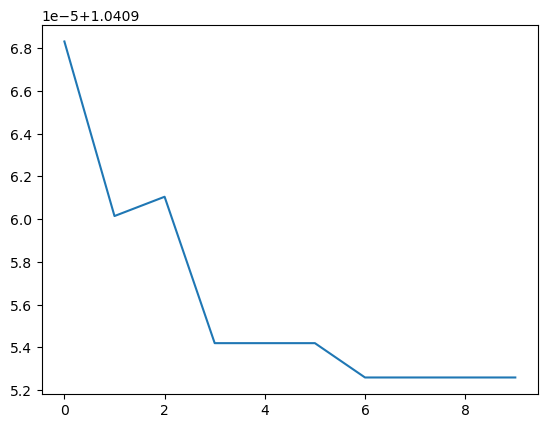

In [56]:
## Training for each segment "inner_epochs" times and getting rolled up predicted and actual rewards at a task level for each epoch
#### Training at a segment level becauce flattening all of X and training in one go was crashing kernel

inner_epochs = 10

def _inner_loop(sigmas):
    task_rewards = []
    task_rewards_actual = []
    for tasks in sigmas:
        episode_rewards = []
        episode_rewards_actual = []
        for episode in tqdm(tasks):
            segments_reward = []
            segments_reward_actual = []
            for segments in episode:
                seg_reward = []
                seg_reward_actual = []
                obs_action = np.hstack((segments['obs'].values.tolist(), segments['action'].values.tolist()))
                reward = torch.tensor(segments['reward'].values.tolist())
                for inner_epoch in range(inner_epochs): # inner_epochs   
                    segments['reward_pred'] = 0
                    optimizer.zero_grad()
                    outputs = reward_model(torch.tensor(obs_action))
                    segments['reward_pred'] = outputs.tolist()
                    loss = criterion(outputs, reward) 
                    loss.backward()
                    optimizer.step()
                    seg_reward.append(np.sum([i[0] for i in outputs.tolist()]))
                    seg_reward_actual.append(np.sum(segments['reward']))
                segments_reward.append(seg_reward)
                segments_reward_actual.append(seg_reward_actual)                   
            episode_rewards.append(seg_reward)
            episode_rewards_actual.append(seg_reward_actual) 
        task_rewards.append(episode_rewards)
        task_rewards_actual.append(episode_rewards_actual)
        
    return model, sigmas, task_rewards, task_rewards_actual



m,sigmas, t_r, t_r_actual = _inner_loop(sigmas)


## Using the rolled up rewards generated in previous step and getting preference loss
### Plot shows mean loss for all segment pairs. (ignored the NaNs and inf but there are many)

seg_pair_loss = []

for ep in range(inner_epochs):
    for i in range(len(t_r)):
        for j in  range ( len (t_r[i])//8 ) : # //8 to reduce compute time ## Need to optimize
            rewards_1 = t_r_actual[i][j][ep]
            reward_pred_1 = t_r[i][j][ep]
            for k in range(len(t_r[i])//8):
                if j!=k:
                    rewards_2 = t_r_actual[i][k][ep]
                    reward_pred_2 = t_r[i][k][ep]
                    p_reward_pred = np.exp(reward_pred_1) / ( np.exp(reward_pred_1) + np.exp(reward_pred_2) )
                    if rewards_1 >= rewards_2:
                        seg_pair_loss.append(-np.log(1 - p_reward_pred))
                    else:
                        seg_pair_loss.append(-np.log(p_reward_pred))
                
        

import matplotlib.pyplot as plt
a = np.array(seg_pair_loss)
b=[]
parts = int(len(a)/inner_epochs)
for i in range(inner_epochs):
    b.append(a[i:i+parts])
c = np.array(b)
e = []
for _ in range(inner_epochs):
    d = c[_]
    e.append(np.mean(d[np.isfinite(d)]))
plt.plot(e)

In [60]:
s[3][9][0]

,obs,action,reward,done,discount,reward_pred
1119,"[0.034663986, 0.5243422, 0.1703135, 0.29937088...","[-9.797433, -0.17872009, -0.6345683, 0.46060854]",4.328230,False,1.0,[4.562683582305908]
1120,"[0.030240217, 0.519522, 0.16670175, 0.299476, ...","[-9.523514, 0.10737329, -0.28555673, 0.5173553]",4.469800,False,1.0,[4.577765941619873]
1121,"[0.024245242, 0.5166351, 0.16294265, 0.2995267...","[-9.39916, 0.13828787, -0.19460854, 0.72149044]",4.651777,False,1.0,[4.5553741455078125]
1122,"[0.017095169, 0.51546377, 0.15935105, 0.299493...","[-9.295212, 0.28544623, -0.14577521, 0.76571876]",4.876531,False,1.0,[4.548862457275391]
1123,"[0.009148297, 0.515637, 0.15615515, 0.29966816...","[-9.170569, 0.12306155, 0.055366706, 0.5336315]",5.140619,False,1.0,[4.558046817779541]
1124,"[0.0006667477, 0.5166879, 0.15349181, 0.300020...","[-9.065167, 0.24371998, 0.025193242, 0.6179144]",5.435490,False,1.0,[4.530896186828613]
1125,"[-0.0066282228, 0.51820445, 0.15152864, 0.3003...","[1.206173, 0.3480522, 0.20350617, 0.55256045]",5.698062,False,1.0,[3.328176736831665]
1126,"[-0.010562294, 0.5197068, 0.1504444, 0.3003856...","[1.5497892, -0.050520375, 0.2747001, 0.6831771]",5.853446,False,1.0,[3.8346567153930664]
1127,"[-0.010860335, 0.5209627, 0.15025213, 0.300428...","[1.4952505, 0.2276854, 0.29635754, 0.45048678]",5.895344,False,1.0,[3.53109073638916]
1128,"[-0.008076727, 0.52212185, 0.15080675, 0.30081...","[1.6421607, 0.32315052, 0.14952779, 0.6711741]",5.841106,False,1.0,[3.3294448852539062]


In [359]:
test = pd.DataFrame()
for name in os.listdir("../datasets/mw_valid"):
    if not (name.startswith('.')):
        dir_name = 'mw_valid/'+name
        print(dir_name)
        df = read_file(dir_name)
        test = pd.concat([data, df])

test.reset_index(drop=True, inplace=True)
Test = PreferenceMAML(test, input_size, hidden_size1, hidden_size2, output_size)
test_X, test_y = Test.prepare_data(k=4)


# Evaluate the model on the test set
def evaluate_model(model, X, y):
    predictions = []
    with torch.no_grad():
        for i in range(len(X)):
            X_tensor = torch.tensor(X[i], dtype=torch.float32)
            output = model.model(X_tensor.unsqueeze(0))  
            predictions.append(output.squeeze().numpy())  

    preds = []
    for _ in range(len(predictions)):
        preds.append((np.array(predictions[_]).mean()))

    pred_label = []
    for i in range(len(preds)):
        pred_label.append([0] if preds[i]>0.5 else [1])
    
    sum = 0
    for _ in range(len(y)):
        sum += pred_label[_]==y[_]
    accuracy = sum/len(y)
    return accuracy, pred_label

test_accuracy, pred_labels = evaluate_model(model, test_X, test_y)
print(f'\nTest Accuracy: {test_accuracy}')

mw_valid/cls_shelf-place-v2
mw_valid/cls_drawer-open-v2
mw_valid/cls_lever-pull-v2
mw_valid/cls_sweep-into-v2

Test Accuracy: 0.6552772808586762


### Without INNER LOOP

In [353]:
# import itertools
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd

# class Model(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, output_size)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x


# class PreferenceMAML:
#     def __init__(
#         self,
#         ml10,
#         input_size,
#         hidden_size1,
#         hidden_size2,
#         output_size,
#         num_support=10,
#         num_query=10,
#         num_inner_steps=5,
#         **kwargs,
#     ):
#         self.ml10 = ml10
#         self.reward_criterion =  nn.CrossEntropyLoss()
#         self.num_support = num_support
#         self.num_query = num_query
#         self.num_inner_steps = num_inner_steps

#         self.model = Model(input_size, hidden_size1, hidden_size2, output_size)

#     def construct_episodes(self):
#         episodes = []
#         episode = []
#         for _, row in self.ml10.iterrows():
#             episode.append(row)
#             if row['done']:
#                 episodes.append(episode)
#                 episode = []
#         return episodes



#     def form_sigma_groups(self, episode, k):
#         sigmas = []
#         segments = []
#         q, r = divmod(len(episode), k)
#         for i in range(k):
#             segments.append(episode[i*q+min(i,r) : (i+1)*q+min(i+1,r)])

#         for i in range(k):
#             sigma_i = segments[i]
#             for j in range(i+1, k):
#                 sigma_j = segments[j]

#                 sigmas.append((sigma_i, sigma_j))
#         return sigmas

#     def compare_probabilities(self, sigma1, sigma2):
#         exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
#         exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
#         prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
#         return [1,0] if prob > 0.5 else [0,1]


#     def prepare_data(self, k):
#         X = []
#         y = []
#         episodes = self.construct_episodes()
#         for episode in episodes:
#             sigmas = self.form_sigma_groups(episode, k)
#             for _ in range(len(sigmas)):

#                 sigma1 = sigmas[_][0]
#                 sigma2 = sigmas[_][1]

#                 obs_action_sigma1 = []
#                 for row in sigma1:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma1.append(obs_action)

#                 obs_action_sigma2 = []
#                 for row in sigma2:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma2.append(obs_action)

#                 if len(obs_action_sigma1) > len(obs_action_sigma2):
#                     obs_action_sigma1 = obs_action_sigma1[1:]
#                 elif len(obs_action_sigma1) < len(obs_action_sigma2):
#                     obs_action_sigma2 = obs_action_sigma2[1:]
#                 else:
#                     continue

#                 X.append(np.concatenate((obs_action_sigma1, obs_action_sigma2), axis = 1))
#                 y.append([self.compare_probabilities(sigma1, sigma2)]) 

#         return X, y


#     def setup_optimizers(self, optim_class, optim_kwargs):
#         self.optim = optim_class(self.model.parameters(), **optim_kwargs)

#     def _train_step(self, X, y):
#         self.optim.zero_grad()
#         loss = self._outer_step(X, y)
#         loss.backward()
#         self.optim.step()
#         return loss.item()

#     def _outer_step(self, X, y):
#         outer_losses = []
#         for i in range(len(X)):
#             loss = self._compute_loss(X[i], y[i])
#             outer_losses.append(loss)
#         return torch.mean(torch.stack(outer_losses))

#     def _compute_loss(self, X, y):
#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         y_tensor = torch.tensor([y], dtype=torch.float32)
#         output = self.model(X_tensor)
#         output_flat = output.view(-1)
#         y_flat = y_tensor.view(-1)
#         loss = self.reward_criterion(output_flat[-2:], y_flat)
#         return loss

# ml10 = data.copy()  
# input_size = 86  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
# hidden_size1 = 128
# hidden_size2 = 128
# output_size = 2
# num_epochs = 20

# model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, output_size)
# model.setup_optimizers(optim.Adam, {"lr": 0.005})

# X, y = model.prepare_data(k=4)

# # Train the model
# for epoch in range(num_epochs):
#     loss = model._train_step(X, y)
#     print(f"Epoch {epoch+1}, Loss: {loss}")


### With INNER LOOP but Improper classification

In [354]:
# import itertools
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd
# from tqdm import tqdm
# import warnings
# warnings.filterwarnings('ignore')

# class Model(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(Model, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, output_size)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x


# class PreferenceMAML:
#     def __init__(
#         self,
#         ml10,
#         input_size,
#         hidden_size1,
#         hidden_size2,
#         output_size,
#         inner_lr = 0.01,
#         num_support=10,
#         num_query=10,
#         num_inner_steps=5,
#         **kwargs,
#     ):
#         self.ml10 = ml10
#         self.reward_criterion =  nn.CrossEntropyLoss()
#         self.num_support = num_support
#         self.num_query = num_query
#         self.num_inner_steps = num_inner_steps
#         self.inner_lr = inner_lr

#         self.model = Model(input_size, hidden_size1, hidden_size2, output_size)

#     def construct_episodes(self):
#         episodes = []
#         episode = []
#         for _, row in self.ml10.iterrows():
#             episode.append(row)
#             if row['done']:
#                 episodes.append(episode)
#                 episode = []
#         return episodes

#     def form_sigma_groups(self, episode, k):
#         sigmas = []
#         segments = []
#         q, r = divmod(len(episode), k)
#         for i in range(k):
#             segments.append(episode[i*q+min(i,r) : (i+1)*q+min(i+1,r)])

#         for i in range(k):
#             sigma_i = segments[i]
#             for j in range(i+1, k):
#                 sigma_j = segments[j]

#                 sigmas.append((sigma_i, sigma_j))
#         return sigmas

#     def compare_probabilities(self, sigma1, sigma2):
#         exp_sum_rewards_sigma1 = np.exp(sum(row['reward'] for row in sigma1))
#         exp_sum_rewards_sigma2 = np.exp(sum(row['reward'] for row in sigma2))
#         prob = exp_sum_rewards_sigma1 / (exp_sum_rewards_sigma1 + exp_sum_rewards_sigma2)
#         return [1,0] if prob > 0.5 else [0,1]

#     def prepare_data(self, k):
#         X = []
#         y = []
#         episodes = self.construct_episodes()
#         for episode in episodes:
#             sigmas = self.form_sigma_groups(episode, k)
#             for _ in range(len(sigmas)):
#                 sigma1 = sigmas[_][0]
#                 sigma2 = sigmas[_][1]

#                 obs_action_sigma1 = []
#                 for row in sigma1:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma1.append(obs_action)

#                 obs_action_sigma2 = []
#                 for row in sigma2:
#                     obs_action = list(row['obs']) + list(row['action'])  # Concatenate obs and action
#                     obs_action_sigma2.append(obs_action)

#                 if len(obs_action_sigma1) > len(obs_action_sigma2):
#                     obs_action_sigma1 = obs_action_sigma1[1:]
#                 elif len(obs_action_sigma1) < len(obs_action_sigma2):
#                     obs_action_sigma2 = obs_action_sigma2[1:]
#                 else:
#                     continue

#                 X.append(np.concatenate((obs_action_sigma1, obs_action_sigma2), axis=1))
#                 y.append(self.compare_probabilities(sigma1, sigma2))

#         return X, y

#     def setup_optimizers(self, optim_class, optim_kwargs):
#         self.optim = optim_class(self.model.parameters(), **optim_kwargs)

#     def _train_step(self, X, y):
#         self.optim.zero_grad()
#         loss = self._outer_step(X, y)
#         loss.backward()
#         self.optim.step()
#         return loss.item()

#     def _outer_step(self, X, y):
#         outer_losses = []
#         for i in tqdm(range(len(X))):
#             if len(X[i])>self.num_support:
#                 support_X, support_y, query_X, query_y = self._split_support_query(X[i], y[i])
#                 # Inner loop (adaptation)
#                 adapted_model = self._inner_loop(support_X, support_y)
#                 # Compute loss using the adapted model on query set
#                 query_loss = self._compute_loss(adapted_model, query_X, query_y)
#                 outer_losses.append(query_loss)
#         return torch.mean(torch.stack(outer_losses))

#     def _inner_loop(self, support_X, support_y):
#         adapted_model = Model(self.model.fc1.in_features, self.model.fc1.out_features,
#                               self.model.fc2.out_features, self.model.fc3.out_features)
#         adapted_model.load_state_dict(self.model.state_dict())

#         inner_optimizer = optim.Adam(adapted_model.parameters(), lr=self.inner_lr)

#         for _ in range(self.num_inner_steps):
#             inner_optimizer.zero_grad()
#             loss = self._compute_loss(adapted_model, support_X, support_y)
#             print(loss)
#             loss.backward()
#             inner_optimizer.step()

#         return adapted_model

#     def _compute_loss(self, model, X, y):
#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         y_class = [0 if y[i]==[1,0] else 1 for i in range(len(y))]
#         y_tensor = torch.tensor(y_class, dtype=torch.long)  # Assuming y is class indices
#         output = model(X_tensor)

#         loss = self.reward_criterion(output, y_tensor)
#         return loss

#     def _split_support_query(self, X, y):
#         num_samples = len(X)
#         all_indices = np.arange(num_samples)
#         # Randomly sample support indices
#         support_indices = np.random.choice(num_samples, self.num_support, replace=False)
#         query_indices = np.setdiff1d(all_indices, support_indices)
#         support_X = X[support_indices]
#         query_X = X[query_indices]
#         # For y, we can simply use the same indices as for X, as it has a fixed length of 2
#         support_y = [y] * self.num_support
#         query_y = [y] * len(query_indices)

#         return support_X, support_y, query_X, query_y


# ml10 = data.copy()  
# input_size = 86  # Assuming obs has 39 numbers and action has 4 numbers * 2 for pair of sigmas
# hidden_size1 = 128
# hidden_size2 = 128
# output_size = 2
# num_epochs = 5
# outer_lr = 0.001

# model = PreferenceMAML(ml10, input_size, hidden_size1, hidden_size2, output_size)
# model.setup_optimizers(optim.Adam, {"lr": outer_lr})

# print('Preparing Data.')
# # X, y = model.prepare_data(k=4)
# print('Data Preparation Done.\n')

# # Train the model
# for epoch in range(num_epochs):
#     print(f'\nBeginning Training - Epoch [{epoch+1}/{num_epochs}]')
#     loss = model._train_step(X, y)
#     print(f"Epoch {epoch+1}, Loss: {loss}")
